#UTKFace age and gender classification

The goal of this notebook is to train NN to correcty identify age and gender of given person. We will be using multitask NN on UTKFace dataset to achive this. 

##### Importing libraries

In [ ]:
import numpy as np 
import pandas as pd 
from subprocess import check_output
import cv2
import time
import os
import itertools
import random
import shutil
import seaborn as sns
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from google.colab import drive

random.seed(42)
np.random.seed(42)
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

##### Mounting drive

In [ ]:
drive.mount('/content/drive', force_remount=True)
path = 'drive/MyDrive/UTKFace/'

Mounted at /content/drive


##EDA

#####Making dataframe from filenames.

In [ ]:
ages = []
genders = []
filenames = []
ethnicity = []
while True:
  try:
    for file_name in os.listdir(path):
        split = file_name.split('_')
        ages.append(int(split[0]))
        genders.append(int(split[1]))
        filenames.append(file_name)
        if len(split) == 4:
            ethnicity.append(int(split[2]))
        else:
            ethnicity.append(4)
    break
  except:
    pass

ages = pd.Series(list(ages), name = 'age')
genders = pd.Series(list(genders), name = 'gender')
ethnicity = pd.Series(list(ethnicity), name = 'ethnicity')
filenames = pd.Series(list(filenames), name = 'filename')
df = pd.concat([ages, genders, ethnicity, filenames], axis=1)
df

age  gender  ethnicity                               filename
0       85       1          0  85_1_0_20170120230116817.jpg.chip.jpg
1        9       0          0   9_0_0_20170110224737016.jpg.chip.jpg
2        8       1          1   8_1_1_20170109203648153.jpg.chip.jpg
3       99       1          1  99_1_1_20170120134639935.jpg.chip.jpg
4       80       0          0  80_0_0_20170117175248197.jpg.chip.jpg
...    ...     ...        ...                                    ...
23731   16       0          0  16_0_0_20170110231909175.jpg.chip.jpg
23732   16       0          0  16_0_0_20170103201044224.jpg.chip.jpg
23733   16       0          0  16_0_0_20170110231725022.jpg.chip.jpg
23734   16       0          0  16_0_0_20170110232301837.jpg.chip.jpg
23735   16       0          0  16_0_0_20170110232012908.jpg.chip.jpg

[23736 rows x 4 columns]

In [ ]:
df.shape

(23736, 4)

As we can see, our dataset consist over 20k imagies of faces. For each image we have information about their age, gender and ethnicity.

In [ ]:
df.describe()

age        gender     ethnicity
count  23721.000000  23721.000000  23721.000000
mean      33.305004      0.476919      1.269002
std       19.867194      0.499478      1.345320
min        1.000000      0.000000      0.000000
25%       23.000000      0.000000      0.000000
50%       29.000000      0.000000      1.000000
75%       45.000000      1.000000      2.000000
max      116.000000      1.000000      4.000000

In dataset we have: 
- 2 genders: 0:"Male",1:"Female"
- 5 ethnicities: 0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"
- people in age 1 to 116

In [ ]:
ethnicity_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}
gender_dict = {0:"Male",1:"Female"}

def display(row):
  age = row[0]
  gender = row[1]
  ethnicity = row[2]
  img = cv2.imread(path+str(row[3])) 
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  try:
    plt.title(f"Age: {age}, Gender: {gender_dict[gender]},\
     Ethnicity: {ethnicity_dict[ethnicity]}")
  except:
    plt.title(f"Age: {age}, Gender: {gender},\
     Ethnicity: {ethnicity_dict[ethnicity]}")
  plt.show()

##### Manualy checking images

After manualy checking imagies, we can spot 2 kinds of errors in dataset:
- images without face
- misslabeled images

In [ ]:
bad_images = ['1_0_0_20170109194120301.jpg.chip.jpg',
              '1_0_0_20170109193052283.jpg.chip.jpg',
              '1_1_0_20170109190852630.jpg.chip.jpg',
              '1_1_0_20170109194452834.jpg.chip.jpg',
              '1_1_4_20170109194502921.jpg.chip.jpg',
              '72_0_0_20170111222516126.jpg.chip.jpg',
              '80_0_2_20170111210646563.jpg.chip.jpg',
              '90_0_0_20170111210338948.jpg.chip.jpg',
              '76_0_1_20170116205556715.jpg.chip.jpg']
wrong_imagies = ['1_0_2_20161219161843718.jpg.chip.jpg',
                 '1_0_3_20170104230640081.jpg.chip.jpg',
                 '1_0_4_20161221193016140.jpg.chip.jpg',
                 '1_0_4_20161221193041157.jpg.chip.jpg',
                 '2_0_0_20170104201100490.jpg.chip.jpg',
                 '2_1_1_20170116231935539.jpg.chip.jpg']

Bad images


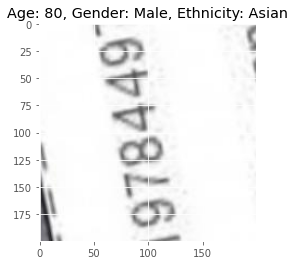

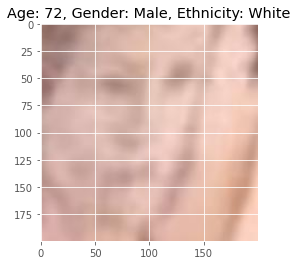

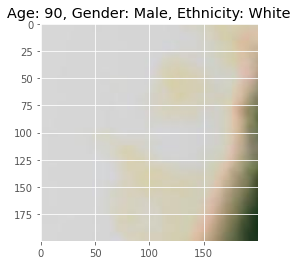

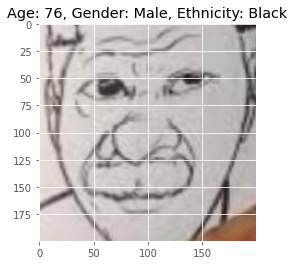

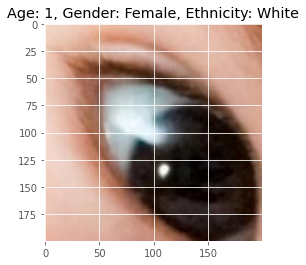

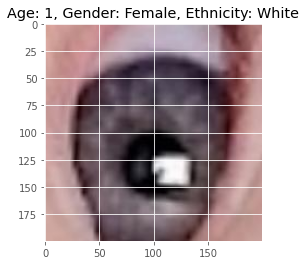

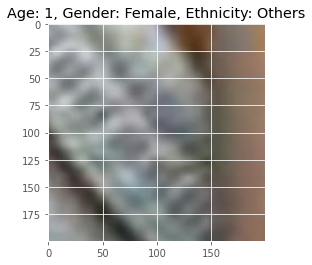

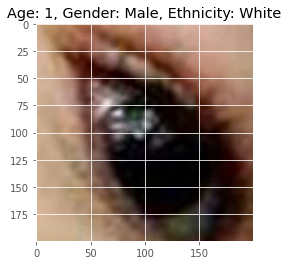

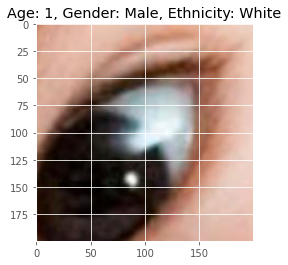

In [ ]:
print("Bad images")

_bad = df.loc[df['filename'].isin(bad_images), :]
[display(row[1]) for row in _bad.iterrows()];

We gonna drop images without face

In [ ]:
df = df.drop(index=[row[0] for row in _bad.iterrows()])

Wrong images:



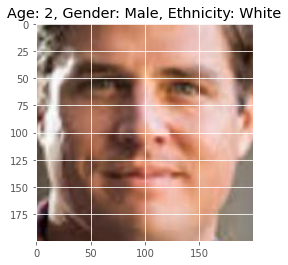

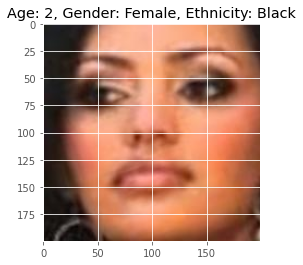

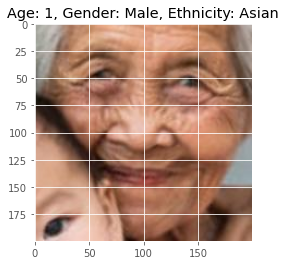

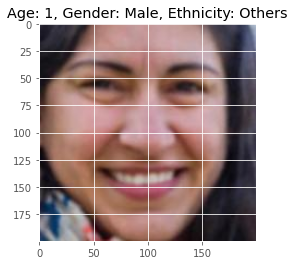

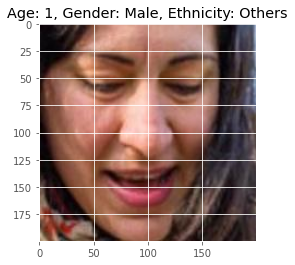

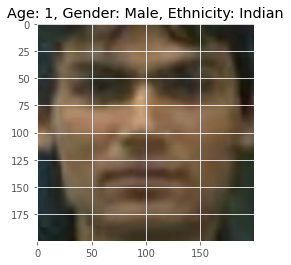

In [ ]:
print("Wrong images:\n")
_wrong = df.loc[df['filename'].isin(wrong_imagies), :]
[display(row[1]) for row in _wrong.iterrows()];


We gonna also drop misslabeled examples

In [ ]:
df = df.drop(index=[row[0] for row in _wrong.iterrows()])

We also have one photo with gender set as 3 (because of missing data label).

In [ ]:
df.gender.value_counts()

0    12408
1    11312
3        1
Name: gender, dtype: int64

In [ ]:
df[df.gender == 3]

age  gender  ethnicity                             filename
999   61       3          4  61_3_20170109150557335.jpg.chip.jpg

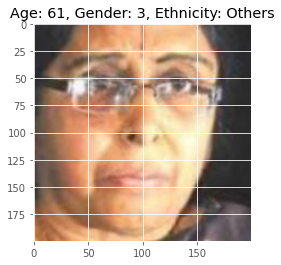

In [ ]:
idx = df[df.gender == 3].index.to_numpy()[0]
display(df[df.index == idx].to_numpy()[0])

We will correct this example

In [ ]:
df.loc[idx,"gender"] = 1
df.loc[idx,"ethnicity"] = 3

Our dataset is preaty balanced in terms of gender.

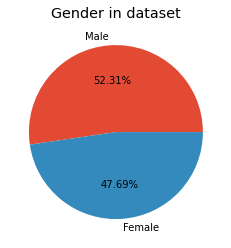

In [ ]:
labels = ["Male","Female"]
gender_count = [sum(df.gender==0), sum(df.gender==1)]
plt.pie(gender_count, labels=labels,autopct = lambda p:f'{p:.2f}%')
plt.title("Gender in dataset");

In our dataset, we have an overwhelmingly large number of records with an age of about 30 years. 

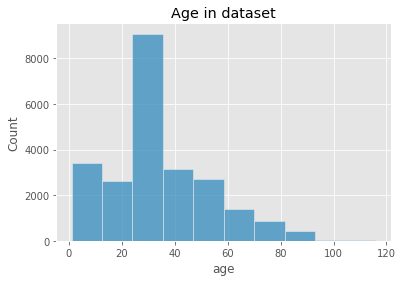

In [ ]:
sns.histplot(df.age, bins=10)
plt.title("Age in dataset");

Women dominates in the lowest and highest age groups, while men dominates when it comes to the group between 40 and 80 years old.

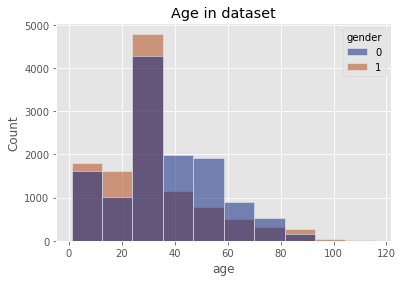

In [ ]:
sns.set_palette(sns.color_palette("dark"), n_colors=None, desat=None, color_codes=False)
sns.histplot(data=df,x="age", hue="gender", multiple="layer", bins=10)
plt.title("Age in dataset");

We have the the highest white people in our set, we can assume that for this skin color the results of our model will be the best.

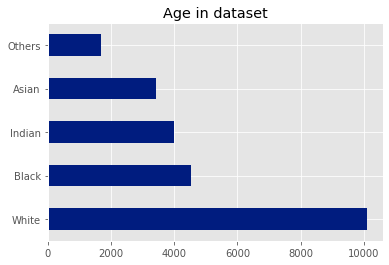

In [ ]:
_d = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}
df.ethnicity.replace(_d).value_counts().plot.barh()
plt.title("Age in dataset");

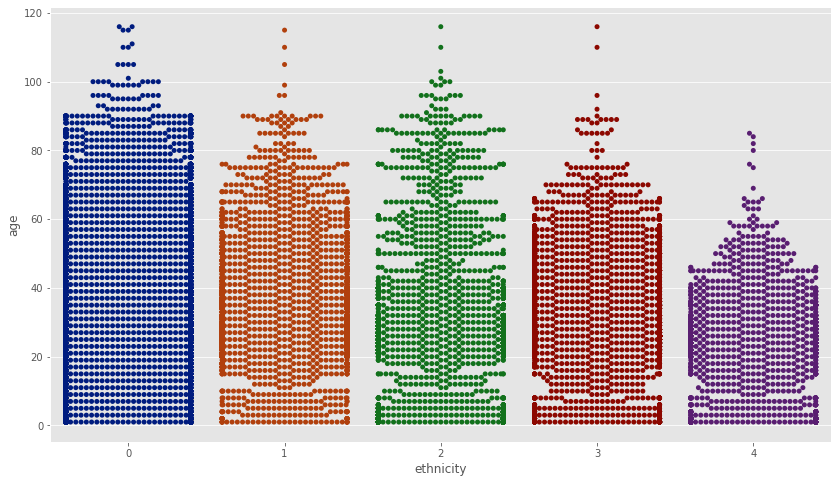

In [ ]:
plt.figure(figsize=(14,8))
sns.swarmplot(data=df, y="age", x="ethnicity");

As show above we don't have any  people in oldest age group with "Other" ethnicity.

##Preprocesing data

Spliting dataset: training, validation and test.

In [ ]:
 from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.2,shuffle  = True)
train, test = train_test_split(train, test_size=0.25,shuffle  = True)
print("Samples in Training:",train.shape[0])
print("Samples in Validation:",valid.shape[0])
print("Samples in Test:",test.shape[0])

Samples in Training: 14232
Samples in Validation: 4745
Samples in Test: 4744


We will be using kerras with tensorflow.

In [ ]:
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

#####Downsizing images

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=False)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    return features

In [ ]:
X_train = extract_features(path+train['filename'])
X_valid = extract_features(path+valid['filename'])
X_test = extract_features(path+test['filename'])

  0%|          | 0/14232 [00:00<?, ?it/s]

  0%|          | 0/4745 [00:00<?, ?it/s]

  0%|          | 0/4744 [00:00<?, ?it/s]

In [ ]:
X_train.shape

(14232, 128, 128, 3)

In [ ]:
X_valid.shape

(4745, 128, 128, 3)

In [ ]:
X_test.shape

(4744, 128, 128, 3)

#####Normalising images

In [ ]:
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

In [ ]:
y_train_gender = np.array(train['gender'])
y_train_age = np.array(train['age'])
y_valid_gender = np.array(valid['gender'])
y_valid_age = np.array(valid['age'])
y_test_gender = np.array(test['gender'])
y_test_age = np.array(test['age'])


input_shape = (128, 128, 3)

##Model

We are using binary_crossentropy loss for gender and mean_absolute_error loss for age.

In [ ]:
inputs = Input((input_shape))
kernel_size=(3, 3)
pool_size=(2, 2)
conv_1 = Conv2D(32, kernel_size=kernel_size, activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=pool_size) (conv_1)
conv_2 = Conv2D(64, kernel_size=kernel_size, activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=pool_size) (conv_2)
conv_3 = Conv2D(128, kernel_size=kernel_size, activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=pool_size) (conv_3)
conv_4 = Conv2D(256, kernel_size=kernel_size, activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=pool_size) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

We are using preaty standard convolution and on top of that two branches one for gender, one for age. 

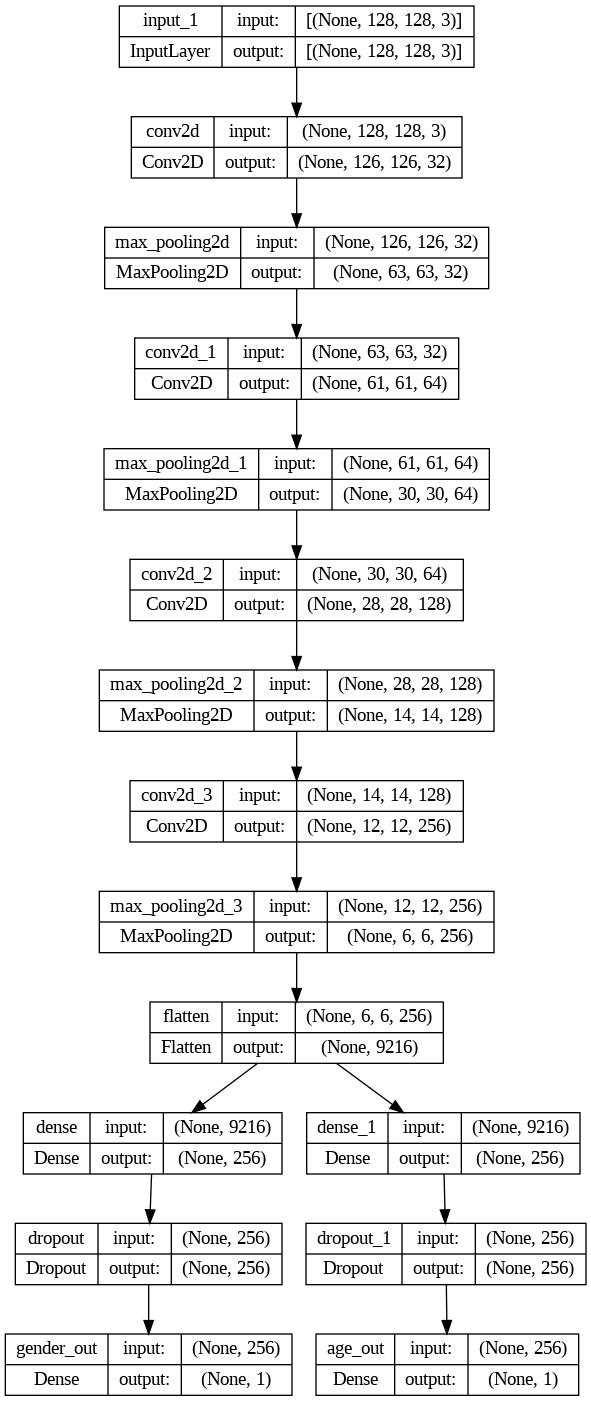

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

We are using batch_size=4 and as many epochs as needed to train (EarlyStoping if validatin loss in no longer dropping)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x=X_train, y=[y_train_gender, y_train_age],
                    batch_size=4,
                    epochs=100, 
                    validation_data=(X_valid,[y_valid_gender,y_valid_age]),
                    callbacks=callback)

Epoch 1/100
3558/3558 [==============================] - 38s 7ms/step - loss: 14.9926 - gender_out_loss: 0.6525 - age_out_loss: 14.3400 - gender_out_accuracy: 0.6005 - age_out_accuracy: 0.0448 - val_loss: 11.9406 - val_gender_out_loss: 0.5175 - val_age_out_loss: 11.4231 - val_gender_out_accuracy: 0.7507 - val_age_out_accuracy: 0.0407
Epoch 2/100
3558/3558 [==============================] - 23s 7ms/step - loss: 11.6163 - gender_out_loss: 0.5044 - age_out_loss: 11.1119 - gender_out_accuracy: 0.7522 - age_out_accuracy: 0.0416 - val_loss: 12.2977 - val_gender_out_loss: 0.4265 - val_age_out_loss: 11.8711 - val_gender_out_accuracy: 0.7983 - val_age_out_accuracy: 0.0449
Epoch 3/100
3558/3558 [==============================] - 23s 6ms/step - loss: 10.1407 - gender_out_loss: 0.4343 - age_out_loss: 9.7064 - gender_out_accuracy: 0.7931 - age_out_accuracy: 0.0461 - val_loss: 9.1337 - val_gender_out_loss: 0.3787 - val_age_out_loss: 8.7550 - val_gender_out_accuracy: 0.8141 - val_age_out_accuracy: 0.

As we can see both losses are acting correctly

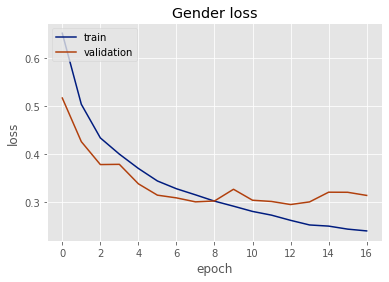

In [ ]:
plt.plot(history.history['gender_out_loss'])
plt.plot(history.history['val_gender_out_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

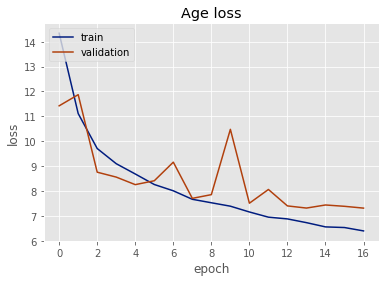

In [ ]:
plt.plot(history.history['age_out_loss'])
plt.plot(history.history['val_age_out_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Predicting few samples

1/1 [==============================] - 0s 135ms/step


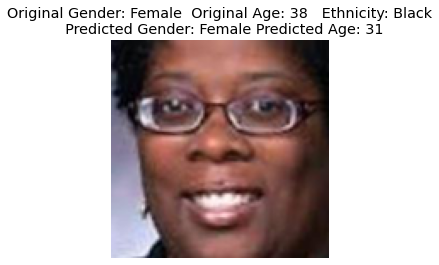

1/1 [==============================] - 0s 23ms/step


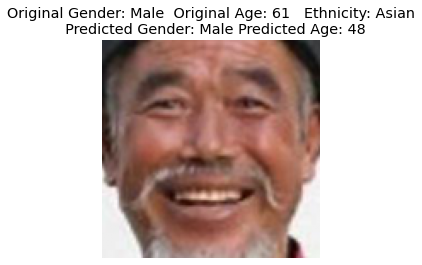

1/1 [==============================] - 0s 24ms/step


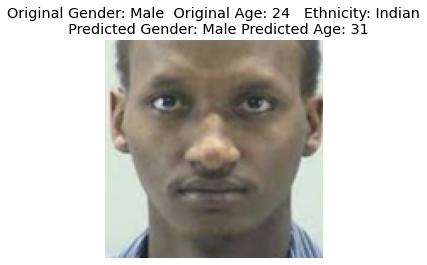

1/1 [==============================] - 0s 24ms/step


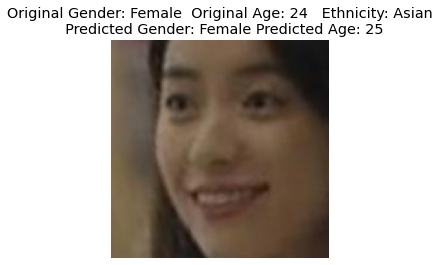

1/1 [==============================] - 0s 30ms/step


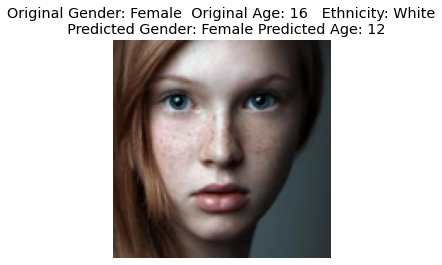

1/1 [==============================] - 0s 26ms/step


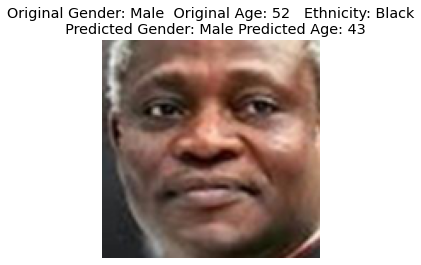

1/1 [==============================] - 0s 23ms/step


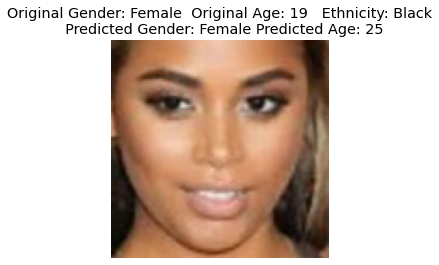

1/1 [==============================] - 0s 23ms/step


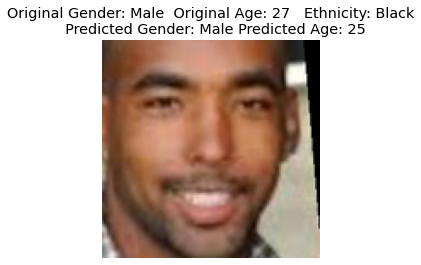

1/1 [==============================] - 0s 25ms/step


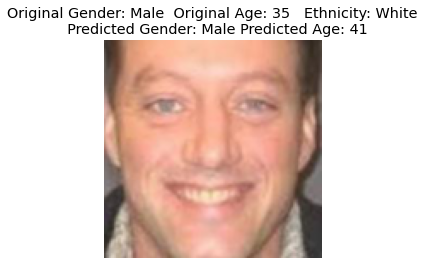

1/1 [==============================] - 0s 28ms/step


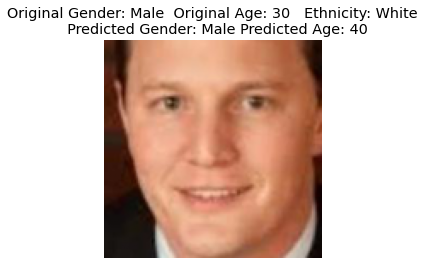

In [ ]:
for image_index in range(10):
  pred = model.predict(X_valid[image_index].reshape(1, 128, 128, 3))
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  plt.title(f'''Original Gender: {gender_dict[y_valid_gender[image_index]]}\
  Original Age: {y_valid_age[image_index]} \
  Ethnicity: {ethnicity_dict[valid.iloc[image_index]["ethnicity"]]}
  Predicted Gender: {pred_gender} Predicted Age: {pred_age}''')
  plt.axis('off')
  plt.imshow(X_valid[image_index])
  plt.show()

###Example with LIME explanaton

Segmenting image

In [ ]:
import skimage.io 
import skimage.segmentation

img_explained = X_valid[9]
superpixels = skimage.segmentation.quickshift(img_explained, kernel_size=2,max_dist=6, ratio=0.3)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

61

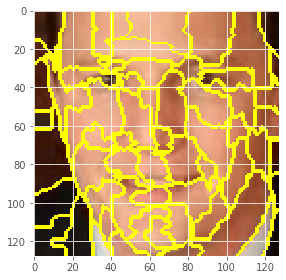

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(img_explained, superpixels));

Making random perturbations

In [ ]:
num_perturb = 1000
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0]

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0])

In [ ]:
import copy

def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

Example perturbation

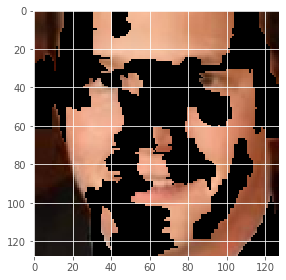

In [ ]:
skimage.io.imshow(perturb_image(img_explained,perturbations[0],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(img_explained,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:].reshape(1,128,128,3))
  predictions.append([[pred[0][0][0], 1-pred[0][0][0]]])
predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 20ms/step


(1000, 1, 2)

In [ ]:
import sklearn

original_image = np.ones(num_superpixels)[np.newaxis,:]
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(1000,)

In [ ]:
kernel_width = 0.5
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))
weights.shape

(1000,)

Predicting best features

In [ ]:
from sklearn.linear_model import LinearRegression

simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,1], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.033228  , -0.00669488, -0.01736708,  0.03553459,  0.02399739,
        0.00607605, -0.03210686,  0.07976715, -0.00791401,  0.00575615,
       -0.0238631 , -0.07306332,  0.00411883, -0.11433983,  0.07112014,
        0.09594679, -0.01983811,  0.00664729, -0.00285326, -0.01209678,
       -0.05837569,  0.01647575,  0.04246891, -0.08900814, -0.05018276,
       -0.05690581, -0.00222886,  0.00982483,  0.00116354, -0.01985094,
       -0.03750193,  0.01539781, -0.00812502,  0.04570498,  0.00261043,
        0.06668691,  0.01443314, -0.01149371, -0.06672049,  0.00583514,
       -0.01528961, -0.00456891,  0.00498378, -0.07501109, -0.01618994,
        0.0385102 , -0.04689571,  0.01952492, -0.00239581, -0.00506943,
       -0.01514943,  0.01779968,  0.009761  , -0.01522247, -0.03610313,
       -0.00536647,  0.00848255, -0.00156416, -0.00106054, -0.02411959,
       -0.0118489 ])

Top 10 features

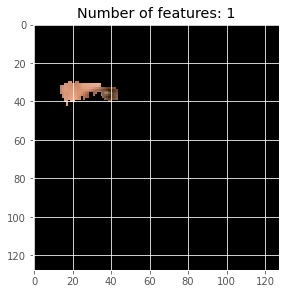

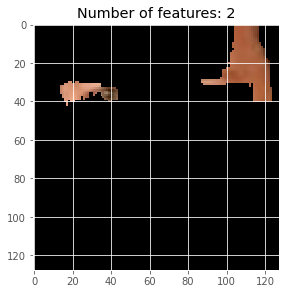

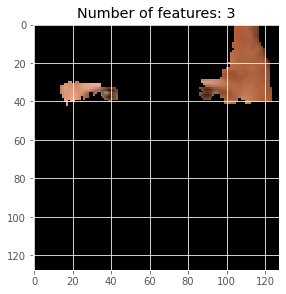

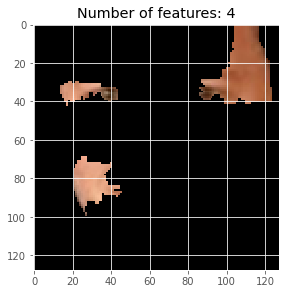

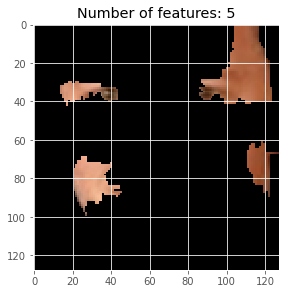

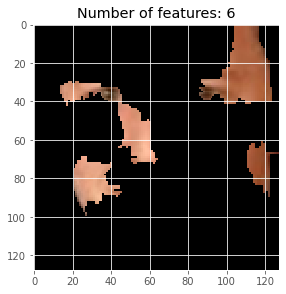

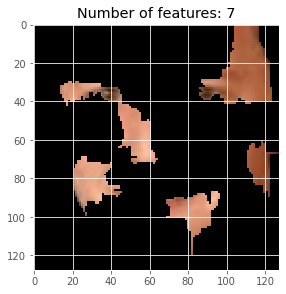

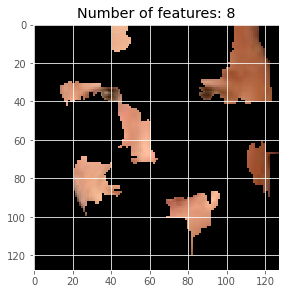

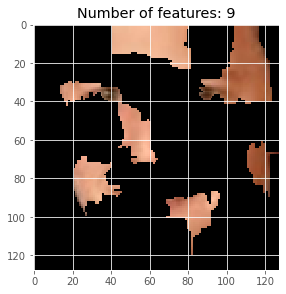

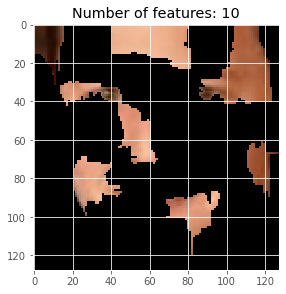

In [ ]:
for num_top_features in range (1,11):
  top_features = np.argsort(coeff)[-num_top_features:] 
  top_features
  mask = np.zeros(num_superpixels) 
  mask[top_features]= True 
  skimage.io.imshow(perturb_image(img_explained,mask,superpixels))
  plt.title(f"Number of features: {len(top_features)}")
  plt.show();

As we can see the most valiable feature for model (when we define gender) is eyes area.

##Test dataset

Now let's look at confusion matrices and R2, MAE scores for test dataset

In [ ]:
test_predictions=[]
for i,X in enumerate(X_test):
  prediction  = model.predict(X.reshape(1,128,128,3))
  test_predictions.append([prediction[0][0][0], prediction[1][0][0]])

1/1 [==============================] - 0s 20ms/step


###Gender

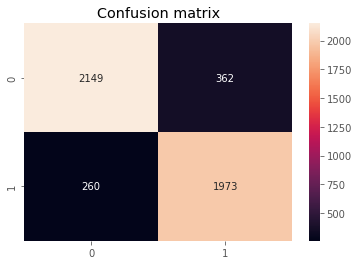

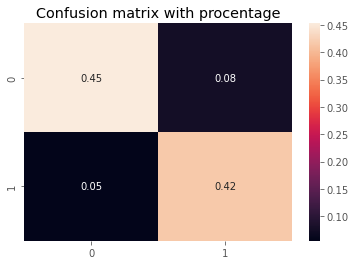

In [ ]:
conf = sklearn.metrics.confusion_matrix(test.gender, [round(gender) for gender, age in test_predictions])
sns.heatmap(conf, annot=True, fmt='g');
plt.title("Confusion matrix")
plt.show()
print("")
sns.heatmap(conf/len(test.gender), annot=True, fmt='.2f');
plt.title("Confusion matrix with procentage");

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test.gender, [round(gender) for gender, age  in test_predictions]))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      2511
           1       0.84      0.88      0.86      2233

    accuracy                           0.87      4744
   macro avg       0.87      0.87      0.87      4744
weighted avg       0.87      0.87      0.87      4744



As metrics show we have great scores (f1 = 0.87) for gender prediction!

###Age

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

score_r2 = r2_score(test.age, [age for gender, age in test_predictions])
score_mae = mean_absolute_error(test.age, [age for gender, age  in test_predictions])
print(f'R2_score = {round(score_r2,3)}')
print(f'mae_score = {round(score_mae,3)}')

R2_score = 0.72
mae_score = 7.226


Scores for age are preaty good, but not so impresive.

Let's check if our model is biased for any etnicity

In [ ]:
pred_0_ethnicity,pred_1_ethnicity,pred_2_ethnicity,pred_3_ethnicity,pred_4_ethnicity=[],[],[],[],[]
for pred, data in zip(test_predictions, test.itertuples()):
  if data[3] == 0:
    pred_0_ethnicity.append([data[2],data[1],*pred])
  if data[3] == 1:
    pred_1_ethnicity.append([data[2],data[1],*pred])
  if data[3] == 2:
    pred_2_ethnicity.append([data[2],data[1],*pred])
  if data[3] == 3:
    pred_3_ethnicity.append([data[2],data[1],*pred])
  if data[3] == 4:
    pred_4_ethnicity.append([data[2],data[1],*pred])

In [ ]:
lists = pred_0_ethnicity,pred_1_ethnicity,pred_2_ethnicity,pred_3_ethnicity,pred_4_ethnicity
for ethnicity, ethnicity_pred in enumerate(lists):
  gender_list = []
  age_list = []
  pred_gender_list = []
  pred_age_list = []
  for  gender, age, pred_gender, pred_age in ethnicity_pred:
    gender_list.append(gender)
    age_list.append(age)
    pred_gender_list.append(round(pred_gender))
    pred_age_list.append(pred_age)
  print(f"classification_report gender for ethnicity: {ethnicity_dict[ethnicity]}")
  print(classification_report(gender_list, pred_gender_list))
  score_r2 = r2_score(age_list, pred_age_list)
  score_mae = mean_absolute_error(age_list, pred_age_list)
  print(f"Scores in age:")
  print(f'R2_score = {round(score_r2,3)}')
  print(f'mae_score = {round(score_mae,3)}\n\n')

classification_report gender for ethnicity: White
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1106
           1       0.85      0.88      0.86       914

    accuracy                           0.87      2020
   macro avg       0.87      0.87      0.87      2020
weighted avg       0.87      0.87      0.87      2020

Scores in age:
R2_score = 0.713
mae_score = 8.266


classification_report gender for ethnicity: Black
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       488
           1       0.91      0.86      0.88       435

    accuracy                           0.89       923
   macro avg       0.89      0.89      0.89       923
weighted avg       0.89      0.89      0.89       923

Scores in age:
R2_score = 0.478
mae_score = 7.523


classification_report gender for ethnicity: Asian
              precision    recall  f1-score   support

           0       0.86      0.75    

We have simmilar results for every ethnicity in terms of both gender and age despite of number of samples! Black people are slightly deviating in terms os age (R2_score=0.478) and for Asians we have weighted avg f1-score 0.82 with is below others.


###Identifying issues

####Gender

In [ ]:
gender_diff = dict()
for data, preds in zip(enumerate(test.itertuples()),test_predictions):
  gender_diff[data[0]] = abs(data[1][2]-preds[0])
worst_pred_gender = sorted(gender_diff.items(), key=lambda x:x[1], reverse=True)[:10]
worst_pred_gender

[(2809, 0.9999999642407786),
 (770, 0.9999957743425512),
 (3503, 0.9999954389172672),
 (318, 0.9999926090240479),
 (1270, 0.9999889574019107),
 (2147, 0.9999861717224121),
 (2266, 0.9999056020387798),
 (3532, 0.9998947381973267),
 (413, 0.9998904466629028),
 (1941, 0.9998508264834527)]

1/1 [==============================] - 0s 24ms/step


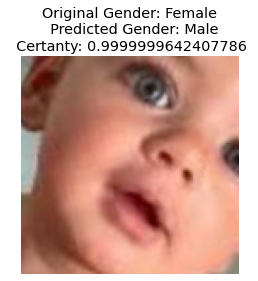

1/1 [==============================] - 0s 26ms/step


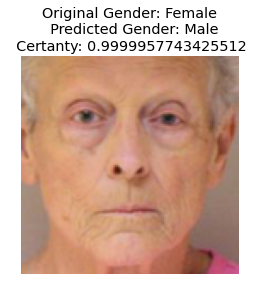

1/1 [==============================] - 0s 27ms/step


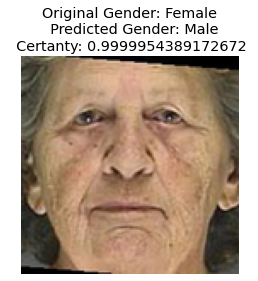

1/1 [==============================] - 0s 23ms/step


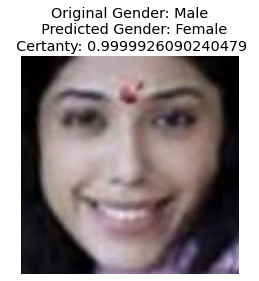

1/1 [==============================] - 0s 23ms/step


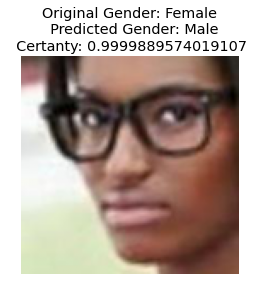

1/1 [==============================] - 0s 23ms/step


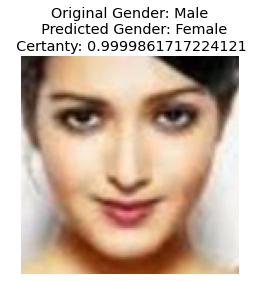

1/1 [==============================] - 0s 25ms/step


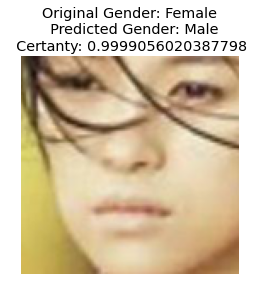

1/1 [==============================] - 0s 22ms/step


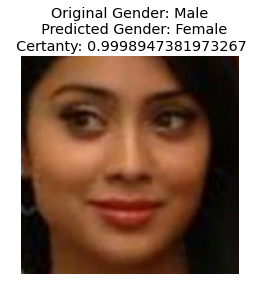

1/1 [==============================] - 0s 22ms/step


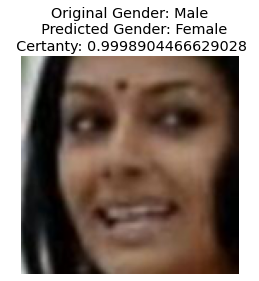

1/1 [==============================] - 0s 22ms/step


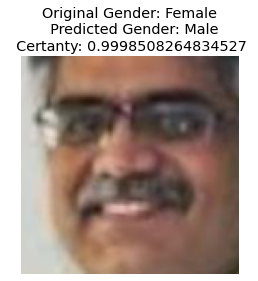

In [ ]:
for image_index, certanty in worst_pred_gender:
  pred = model.predict(X_test[image_index].reshape(1, 128, 128, 3))
  pred_gender = gender_dict[round(pred[0][0][0])]
  pred_age = round(pred[1][0][0])
  plt.title(f'''Original Gender: {gender_dict[y_test_gender[image_index]]}
  Predicted Gender: {pred_gender}
  Certanty: {certanty} ''')
  plt.axis('off')
  plt.imshow(X_test[image_index])
  plt.show()

As we can see there are some problems with older people,neborn baby's and we still have probably some misslabeled data. Few woman also has been misclassified without any obvious reason, let's focuse at one of them.

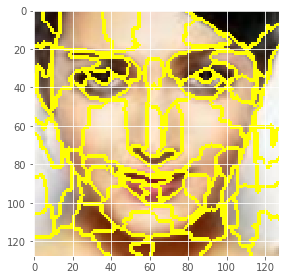

In [ ]:
img_explained = X_test[2147]
superpixels = skimage.segmentation.quickshift(img_explained, kernel_size=2,max_dist=6, ratio=0.3)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(img_explained, superpixels));

1/1 [==============================] - 0s 19ms/step


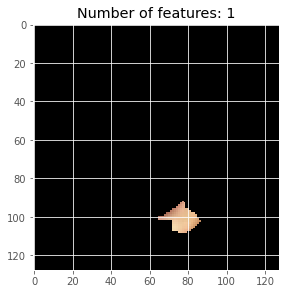

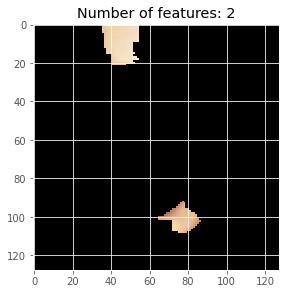

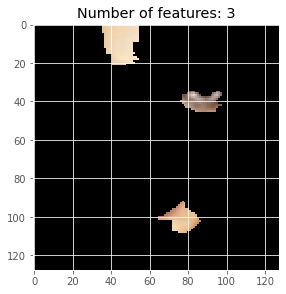

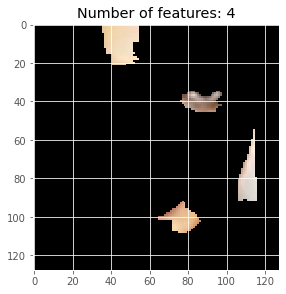

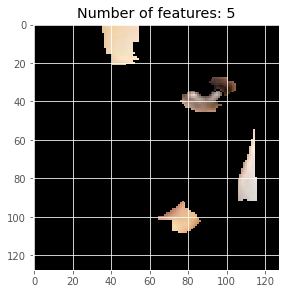

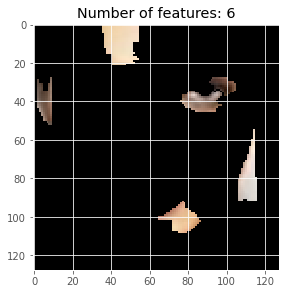

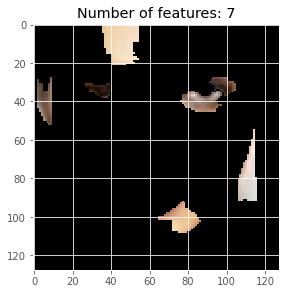

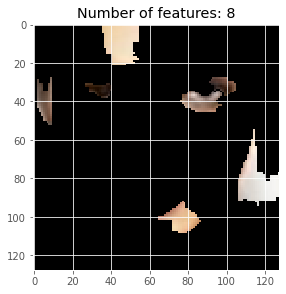

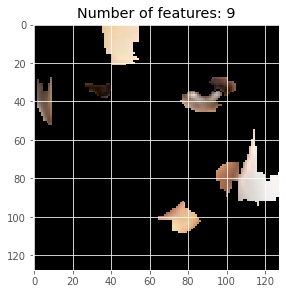

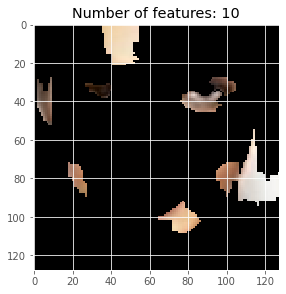

In [ ]:
num_perturb = 1000
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(img_explained,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:].reshape(1,128,128,3))
  predictions.append([[pred[0][0][0], 1-pred[0][0][0]]])
predictions = np.array(predictions)
original_image = np.ones(num_superpixels)[np.newaxis,:]
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
kernel_width = 0.5
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,1], sample_weight=weights)
coeff = simpler_model.coef_[0]
for num_top_features in range (1,11):
  top_features = np.argsort(coeff)[-num_top_features:] 
  top_features
  mask = np.zeros(num_superpixels) 
  mask[top_features]= True 
  skimage.io.imshow(perturb_image(img_explained,mask,superpixels))
  plt.title(f"Number of features: {len(top_features)}")
  plt.show();

Model focused mainly on forhead, chicks, eyes but it also focused on backgound behind woman which is preaty strange. Probaly more samples would supres this effect.

####Age

In [ ]:
age_diff = dict()
for data, preds in zip(enumerate(test.itertuples()),test_predictions):
  age_diff[data[0]] = abs(data[1][1]-preds[1])
worst_pred_age = sorted(age_diff.items(), key=lambda x:x[1], reverse=True)[:10]
worst_pred_age

[(1620, 61.62664794921875),
 (3173, 60.486209869384766),
 (1839, 56.100419998168945),
 (3159, 51.010257720947266),
 (2652, 50.3026008605957),
 (2770, 48.80824089050293),
 (842, 47.9011287689209),
 (2754, 47.21883010864258),
 (1581, 47.12103843688965),
 (793, 46.91650199890137)]

1/1 [==============================] - 0s 34ms/step


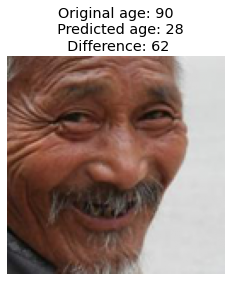

1/1 [==============================] - 0s 35ms/step


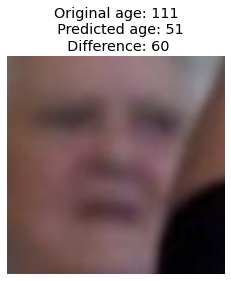

1/1 [==============================] - 0s 31ms/step


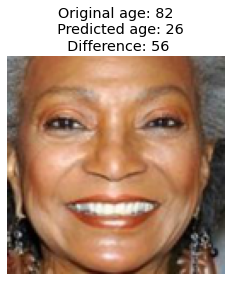

1/1 [==============================] - 0s 30ms/step


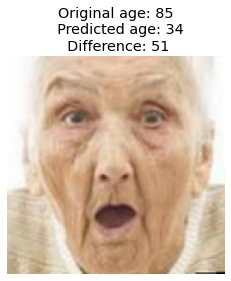

1/1 [==============================] - 0s 30ms/step


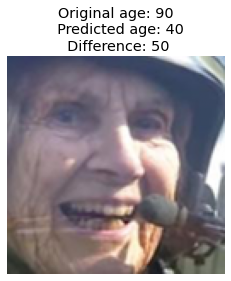

1/1 [==============================] - 0s 29ms/step


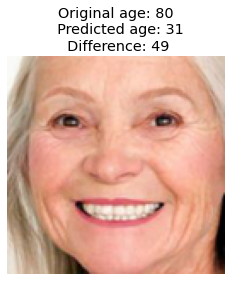

1/1 [==============================] - 0s 34ms/step


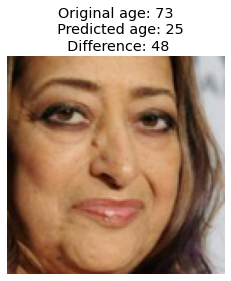

1/1 [==============================] - 0s 43ms/step


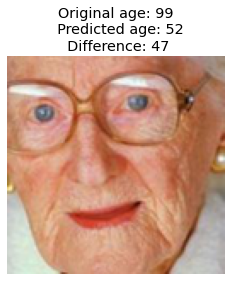

1/1 [==============================] - 0s 45ms/step


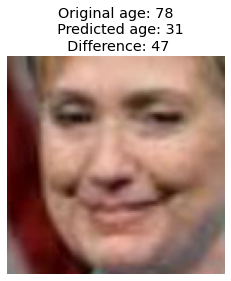

1/1 [==============================] - 0s 37ms/step


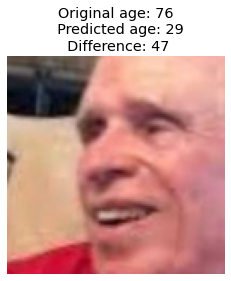

In [ ]:
for image_index, diff in worst_pred_age:
  pred = model.predict(X_test[image_index].reshape(1, 128, 128, 3))
  pred_age = round(pred[1][0][0])
  plt.title(f'''Original age: {y_test_age[image_index]}
  Predicted age: {pred_age}
  Difference: {round(diff)} ''')
  plt.axis('off')
  plt.imshow(X_test[image_index])
  plt.show()

This shows that model strugles with older people (above 70yo.) in terms of age. It probalby because we don't have enought samples of people in this age group. We could overcome this issue by putting weight on certine age groups or/and gave our model age in logaritmic scale.  

Conclusions:
- Dataset consists high amount of wrong/misslabed samples.
- Model don't have high biase for any etnicity.
- Model have some bias in terms of age.
- Model did very good job in terms of both age and gender.
- Model could be deployed as some smartphone app to predict age/gender, but for any critical task results should be double checked by humans. 